# ASHRAE Great Energy Predictor
### *by Jose Correa*

# Introduction

The problem statement revolves around the inefficiency and uncertainty in evaluating the effectiveness of building retrofits and their impact on energy consumption.

The solution presented by the project involves implementing the Building Energy Consumption Predictor (BECP) model. This model aims to resolve the inefficiencies and uncertainties in evaluating the effectiveness of building retrofits by providing precise predictions of metered building energy usage across categories such as chilled water, electric, hot water, and steam meters. Additionally, it empowers building owners to confidently assess the efficacy of their retrofit investments, offering a clear understanding of whether the retrofits are financially sound and if the improvements align with anticipated energy and sustainability goalss.

<a id='toc'></a>

# Table of Contents

1. [Data dictionary](#data-d)
2. [Basic Data Wrangling](#bdw-0)
    1. [Files merging](#bdw-1)
    2. [Subset](#bdw-2)
3. [Healthcare subset](#hea-0)
    1. [Data wrangling](#hea-1)
    2. [Numeric columns](#hea-2)
    3. [`Meter_reading` data analysis](#hea-3)
    4. [`dew_temperature` data analysis](#hea-4)
    5. [`meter`, `cloud_coverage` data analysis](#hea-5)
    6. [`building_id` data analysis](#hea-6)
    7. [Remove unnecessary and duplicated columns](#hea-7)
    8. [Null values analysis](#hea-8)
4. [PLACE HOLDER - Statistical Analysis](#sa-0)
    1. [Statistically significant difference..](#sa-1)
    2. [Correlation with ??](#sa-2)
5. [PLACE HOLDER - Advanced Statistical Analysis](#asa-0)
    1. [Linear regression for ??](#asa-1)
    2. [Logistic regression for ??](#asa-2)
6. [PLACE HOLDER - Conclusion](#concl)

<a id='data-d'></a>

# Data dictionary

- `building_id`, foreign key for the building metadata.- `meter`, the  meter id code. Read as {0: electricity, 1: chilled water, 2: steam, 3: hot water}.  Not every building has all meter types.
- `meter_timestamp`, when the measurement was taken. Same as `weather_timestamp`.
- `meter_reading`, the target variable. Energy consumption in kWh (or equivalent).
- `site_id`, foreign key for the weather files.
- `primary_use`, indicator of the primary category of activities for the building.
- `square_feet`, gross floor area of the building in ft2.
- `year_built`, year building was opened.
- `floor_count`, number of floors of the building.
- `weather_timestamp`, when the measurement was taken. Same as `meter_timestamp`.
- `air_temperature`, degrees celsius.
- `cloud_coverage`, portion of the sky covered in clouds, in oktas.
- `dew_temperature`, degrees celsius.
- `precip_depth_1_hr`, millimeters.
- `sea_level_pressure`, millibar/hectopascals.
- `wind_direction`, compass direction (0-360).
- `wind_speed`, meters/second (m/s).


<a id='bdw-0'></a>

[back to TOC](#toc)

# 1. Basic Data Wrangling

In [1]:
# Import Python packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Setting figure size
plt.rcParams['figure.figsize']=(8.0,6.0)

<a id='bdw-1'></a>

## 1.1. Files merging
**MERGE DONE LOCALLY**, the raw files are too large to upload to GitHub.\
The interrelated files are: train.csv, building_metadata.csv, weather_train.csv

### 1.1.1. 'train' file analysis

In [2]:
# Data loading, the CSV file is coma (,) separated. 
# The index is auto generated, since the 'building_id' column doesn't have unique values
train_df = pd.read_csv('data/train.csv', sep = ',')
display (train_df.head(3))

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0


In [3]:
# General info
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   building_id    int64  
 1   meter          int64  
 2   timestamp      object 
 3   meter_reading  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 616.9+ MB


### 1.1.2. 'building_meta' file analysis

In [4]:
# Data loading, the CSV file is coma (,) separated. 
# The index is auto generated, since the 'building_id' column doesn't have unique values
building_df = pd.read_csv('data/building_metadata.csv', sep = ',')
display (building_df.head(3))

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN


In [5]:
# General info
building_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   site_id      1449 non-null   int64  
 1   building_id  1449 non-null   int64  
 2   primary_use  1449 non-null   object 
 3   square_feet  1449 non-null   int64  
 4   year_built   675 non-null    float64
 5   floor_count  355 non-null    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.1+ KB


### 1.1.3. Merging 'train_df' and 'building_df'

In [6]:
# Inner merge of the dataframes 'train_df' and 'building_df' on 'building_id'
train_building_df = train_df.merge(building_df, on='building_id', how='inner')
train_building_df.sample(3)

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count
12927674,1055,0,2016-12-13 03:00:00,32.415,12,Education,86714,NaN,4.0
8605579,787,2,2016-10-12 22:00:00,1075.900,6,Lodging/residential,278795,NaN,NaN
17928382,1309,0,2016-10-06 22:00:00,65.880,14,Lodging/residential,58041,NaN,NaN


In [7]:
# Review merged dataframe
train_building_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   building_id    int64  
 1   meter          int64  
 2   timestamp      object 
 3   meter_reading  float64
 4   site_id        int64  
 5   primary_use    object 
 6   square_feet    int64  
 7   year_built     float64
 8   floor_count    float64
dtypes: float64(3), int64(4), object(2)
memory usage: 1.4+ GB


### 1.1.4. 'Weather_train' file analysis

In [8]:
# Data loading, the CSV file is coma (,) separated. 
# The index is auto generated, since the 'site_id' column doesn't have unique values
weather_train_df = pd.read_csv('data/weather_train.csv', sep = ',')
weather_train_df.sample(3)

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
137878,15,2016-10-12 19:00:00,20.6,0.0,9.4,NaN,NaN,160.0,6.7
106711,12,2016-03-12 13:00:00,13.2,7.0,5.1,NaN,1027.3,220.0,7.0
18217,2,2016-01-28 22:00:00,20.6,NaN,-7.2,0.0,1017.9,0.0,0.0


In [9]:
# General info
weather_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   site_id             139773 non-null  int64  
 1   timestamp           139773 non-null  object 
 2   air_temperature     139718 non-null  float64
 3   cloud_coverage      70600 non-null   float64
 4   dew_temperature     139660 non-null  float64
 5   precip_depth_1_hr   89484 non-null   float64
 6   sea_level_pressure  129155 non-null  float64
 7   wind_direction      133505 non-null  float64
 8   wind_speed          139469 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 9.6+ MB


### 1.1.5. Rename `timestamp` column header 

In [10]:
# Rename the 'timestamp' column to 'meter_timestamp' to avoid ambiguity
train_building_df.rename(columns={'timestamp': 'meter_timestamp'}, inplace=True)

In [11]:
# Verify renaming
train_building_df.head(3)

,building_id,meter,meter_timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN
1,0,0,2016-01-01 01:00:00,0.0,0,Education,7432,2008.0,NaN
2,0,0,2016-01-01 02:00:00,0.0,0,Education,7432,2008.0,NaN


In [12]:
# For 'weather_train_df' rename the `timestamp` column to `weather_timestamp`
weather_train_df.rename(columns={'timestamp': 'weather_timestamp'}, inplace=True)

In [13]:
# Verify renaming
weather_train_df.head(3)

,site_id,weather_timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0


### 1.1.5 Merge 'train_building_df' with 'weather_train.df'

In [14]:
# Merge the dataframe files on 'site_id' and 'meter_timestamp' equal to 'site_id' and 'weather_timestamp'. Left join to keep all 'train_building_df' records.
merged_train_df = train_building_df.merge(weather_train_df, left_on=['site_id', 'meter_timestamp'], right_on=['site_id', 'weather_timestamp'], how='left')

In [15]:
# Visualize new dataframe
merged_train_df.sample(3)

,building_id,meter,meter_timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,weather_timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
8207001,760,0,2016-12-30 08:00:00,143.1,6,Office,49990,NaN,NaN,2016-12-30 08:00:00,3.9,0.0,-8.3,0.0,1008.7,280.0,3.6
19300620,1387,0,2016-07-25 10:00:00,211.4,15,Office,187041,1973.0,NaN,2016-07-25 10:00:00,17.8,0.0,15.6,NaN,1013.5,80.0,2.6
18719686,1351,0,2016-07-02 06:00:00,14.5,15,Office,40611,NaN,NaN,2016-07-02 06:00:00,14.4,NaN,12.2,NaN,1014.5,300.0,4.1


In [16]:
# Overview of the new dataframe
merged_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 17 columns):
 #   Column              Dtype  
---  ------              -----  
 0   building_id         int64  
 1   meter               int64  
 2   meter_timestamp     object 
 3   meter_reading       float64
 4   site_id             int64  
 5   primary_use         object 
 6   square_feet         int64  
 7   year_built          float64
 8   floor_count         float64
 9   weather_timestamp   object 
 10  air_temperature     float64
 11  cloud_coverage      float64
 12  dew_temperature     float64
 13  precip_depth_1_hr   float64
 14  sea_level_pressure  float64
 15  wind_direction      float64
 16  wind_speed          float64
dtypes: float64(10), int64(4), object(3)
memory usage: 2.6+ GB


In [17]:
# Shape
merged_train_df.shape

(20216100, 17)

[back to TOC](#toc)

<a id='bdw-2'></a>

## 1.2. Subset
Select a subset of ~ 400k rows to facilitate PC process time. 

In [23]:
# Main use buildings records count.
# Count by unique values
count_by_primary_use = merged_train_df.groupby(['primary_use'])['primary_use'].count()

# Sort descending
count_by_primary_use = count_by_primary_use.sort_values(ascending=True)
count_by_primary_use

primary_use
Religious worship                  32361
Utility                            56203
Technology/science                 77627
Services                           96519
Warehouse/storage                 111861
Retail                            112657
Food sales and service            114090
Manufacturing/industrial          125713
Parking                           213796
Other                             242222
Healthcare                        398527
Public services                  1662826
Lodging/residential              2146413
Entertainment/public assembly    2264917
Office                           4394864
Education                        8165504
Name: primary_use, dtype: int64

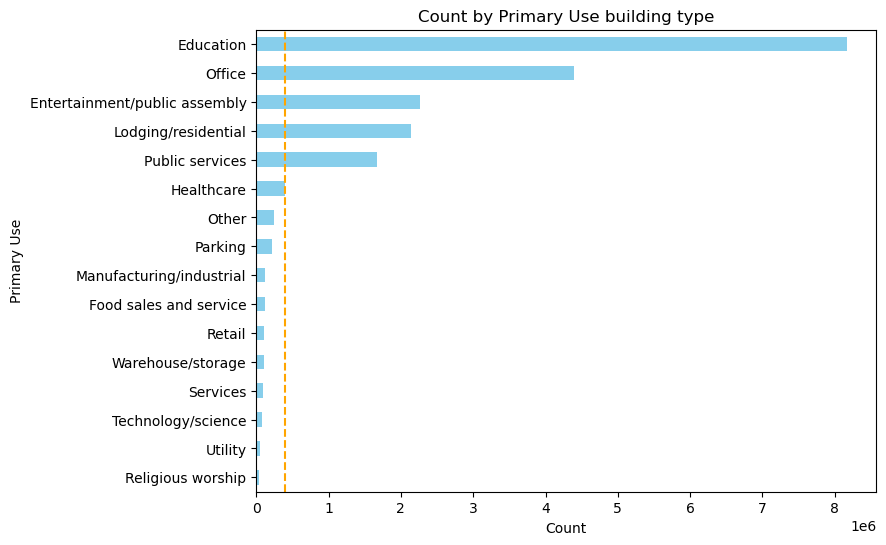

In [31]:
# Chart for 'primary_use', showing 'Healthcare' as the category to use for the subset

# Create horizontal bar
plt.figure(figsize=(8,6))
count_by_primary_use.plot(kind='barh', color='skyblue')

plt.xlabel('Count')
plt.ylabel('Primary Use')
plt.title('Count by Primary Use building type')

# Adding a dotted vertical line at count = 400000
plt.axvline(x=400000, color='orange', linestyle='--')

plt.show()

### 1.2.1. Data distribution for `meter_reading` for each building type

<Axes: xlabel='meter_reading', ylabel='Count'>

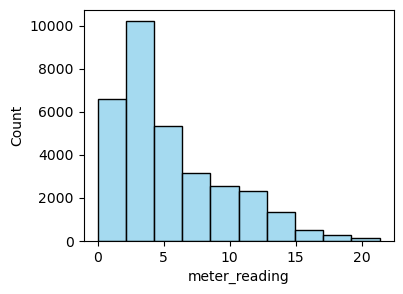

In [42]:
# Data distribution where 'primary_use' is 'Education'
education_data = merged_train_df[merged_train_df['primary_use'] == 'Religious worship']
# Create histogram using Seaborn
plt.figure(figsize=(4,3))
sns.histplot(education_data['meter_reading'], bins=10, color='skyblue')

<Axes: xlabel='meter_reading', ylabel='Count'>

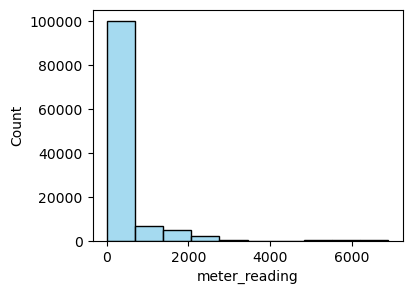

In [41]:
# Data distribution where 'primary_use' is 'Food sales and service'
education_data = merged_train_df[merged_train_df['primary_use'] == 'Food sales and service']
# Create histogram using Seaborn
plt.figure(figsize=(4,3))
sns.histplot(education_data['meter_reading'], bins=10, color='skyblue')

<Axes: xlabel='meter_reading', ylabel='Count'>

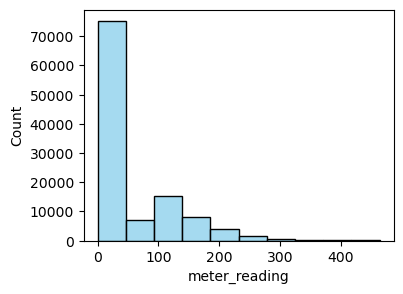

In [40]:
# Data distribution where 'primary_use' is 'Warehouse/storage'
education_data = merged_train_df[merged_train_df['primary_use'] == 'Warehouse/storage']
# Create histogram using Seaborn
plt.figure(figsize=(4,3))
sns.histplot(education_data['meter_reading'], bins=10, color='skyblue')

<Axes: xlabel='meter_reading', ylabel='Count'>

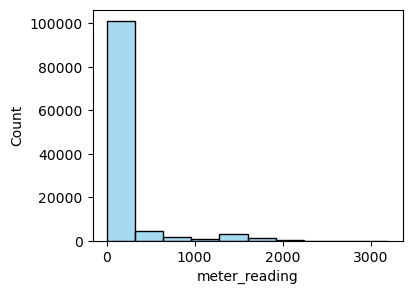

In [37]:
# Data distribution where 'primary_use' is 'Retail'
education_data = merged_train_df[merged_train_df['primary_use'] == 'Retail']
# Create histogram using Seaborn
plt.figure(figsize=(4,3))
sns.histplot(education_data['meter_reading'], bins=10, color='skyblue')

<Axes: xlabel='meter_reading', ylabel='Count'>

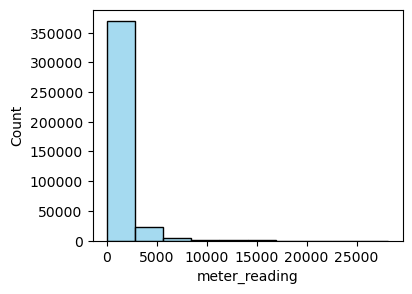

In [43]:
# Data distribution where 'primary_use' is 'Healthcare'
education_data = merged_train_df[merged_train_df['primary_use'] == 'Healthcare']
# Create histogram using Seaborn
plt.figure(figsize=(4,3))
sns.histplot(education_data['meter_reading'], bins=10, color='skyblue')

<Axes: xlabel='meter_reading', ylabel='Count'>

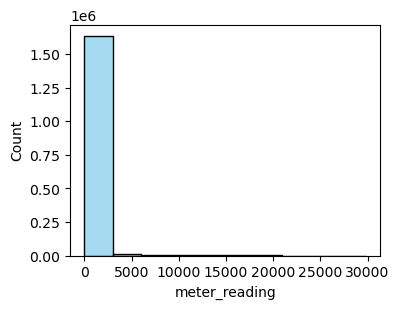

In [39]:
# Data distribution where 'primary_use' is 'Public services'
education_data = merged_train_df[merged_train_df['primary_use'] == 'Public services']
# Create histogram using Seaborn
plt.figure(figsize=(4,3))
sns.histplot(education_data['meter_reading'], bins=10, color='skyblue')

<Axes: xlabel='meter_reading', ylabel='Count'>

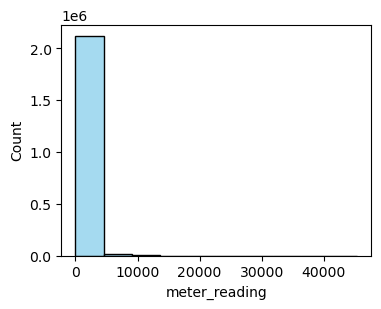

In [33]:
# Data distribution where 'primary_use' is 'Lodging/residential'
education_data = merged_train_df[merged_train_df['primary_use'] == 'Lodging/residential']
# Create histogram using Seaborn
plt.figure(figsize=(4,3))
sns.histplot(education_data['meter_reading'], bins=10, color='skyblue')

<Axes: xlabel='meter_reading', ylabel='Count'>

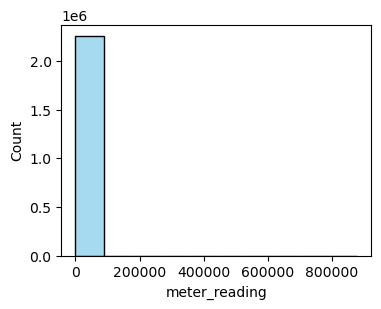

In [36]:
# Data distribution where 'primary_use' is 'Entertainment/public assembly'
education_data = merged_train_df[merged_train_df['primary_use'] == 'Entertainment/public assembly']
# Create histogram using Seaborn
plt.figure(figsize=(4,3))
sns.histplot(education_data['meter_reading'], bins=10, color='skyblue')

<Axes: xlabel='meter_reading', ylabel='Count'>

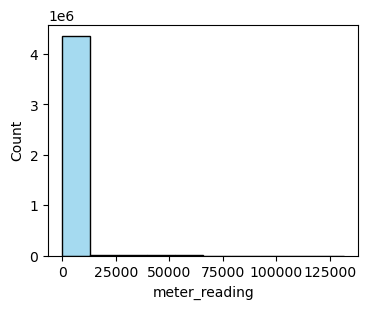

In [35]:
# Data distribution where 'primary_use' is 'Office'
education_data = merged_train_df[merged_train_df['primary_use'] == 'Office']
# Create histogram using Seaborn
plt.figure(figsize=(4,3))
sns.histplot(education_data['meter_reading'], bins=10, color='skyblue')

<Axes: xlabel='meter_reading', ylabel='Count'>

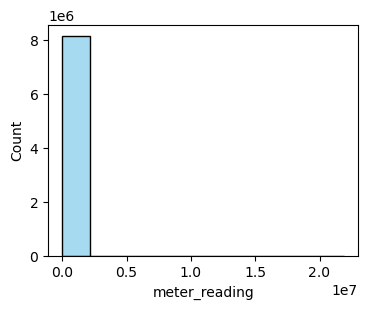

In [34]:
# Filter data where 'primary_use' is 'Education'
education_data = merged_train_df[merged_train_df['primary_use'] == 'Education']

# Create histogram using Seaborn
plt.figure(figsize=(4,3))
sns.histplot(education_data['meter_reading'], bins=10, color='skyblue')

Continue analysis only with the Healthcare category, comprising of 397,992 rows.

In [36]:
# Filter the DataFrame to include only rows where 'primary_use' is 'Healthcare'
healthcare_train_df = merged_train_df[merged_train_df['primary_use'] == 'Healthcare']
healthcare_train_df

,building_id,meter,meter_timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,weather_timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
2600276,208,0,2016-01-01 00:00:00,77.2900,2,Healthcare,36904,1934.0,NaN,2016-01-01 00:00:00,15.6,6.0,-5.6,NaN,1015.3,270.0,3.6
2600277,208,1,2016-01-01 00:00:00,0.1055,2,Healthcare,36904,1934.0,NaN,2016-01-01 00:00:00,15.6,6.0,-5.6,NaN,1015.3,270.0,3.6
2600278,208,0,2016-01-01 01:00:00,87.0900,2,Healthcare,36904,1934.0,NaN,2016-01-01 01:00:00,13.9,NaN,-5.6,0.0,1015.6,270.0,4.1
2600279,208,1,2016-01-01 01:00:00,0.1407,2,Healthcare,36904,1934.0,NaN,2016-01-01 01:00:00,13.9,NaN,-5.6,0.0,1015.6,270.0,4.1
2600280,208,0,2016-01-01 02:00:00,90.5100,2,Healthcare,36904,1934.0,NaN,2016-01-01 02:00:00,13.3,2.0,-5.6,0.0,1016.0,270.0,3.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19315319,1388,1,2016-12-31 19:00:00,32.8303,15,Healthcare,45465,1990.0,NaN,2016-12-31 19:00:00,3.0,NaN,-8.0,NaN,NaN,180.0,5.7
19315320,1388,1,2016-12-31 20:00:00,28.9841,15,Healthcare,45465,1990.0,NaN,2016-12-31 20:00:00,2.8,2.0,-8.9,NaN,1007.4,180.0,7.7
19315321,1388,1,2016-12-31 21:00:00,25.0044,15,Healthcare,45465,1990.0,NaN,2016-12-31 21:00:00,2.8,NaN,-7.2,NaN,1007.5,180.0,5.1
19315322,1388,1,2016-12-31 22:00:00,22.3746,15,Healthcare,45465,1990.0,NaN,2016-12-31 22:00:00,2.2,NaN,-6.7,NaN,1008.0,170.0,4.6


In [37]:
# Export dataframe to a csv file
healthcare_train_df.to_csv('data/01_healthcare_train_df.csv', index=False)

[back to TOC](#toc)

<a id='hea-0'></a>

# 3. Healthcare subset

In [1]:
# Import analysis packages
import pandas as pd
import numpy as np

# import plotting packages
import matplotlib.pyplot as plt
import seaborn as sns

# Setting figure size
plt.rcParams['figure.figsize']=(8.0,6.0)

[back to TOC](#toc)

<a id='hea-1'></a>

## 3.1. Data wrangling

In [2]:
# Data loading for healthcare.csv saved from section above 'Basic Data Wrangling' . The file is coma (,) separated. The index is auto generated
healthcare_df=pd.read_csv('data/01_healthcare_train_df.csv',sep=',')
healthcare_df.sample(3)

,building_id,meter,meter_timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,weather_timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
172555,1241,2,2016-06-02 14:00:00,1643.000,14,Healthcare,194188,NaN,NaN,2016-06-02 14:00:00,19.4,4.0,15.0,0.0,1019.9,80.0,3.6
357376,1303,0,2016-01-19 07:00:00,584.128,14,Healthcare,200000,NaN,NaN,2016-01-19 07:00:00,-8.9,0.0,-17.2,0.0,1017.8,290.0,5.1
80919,1072,2,2016-02-11 00:00:00,0.000,13,Healthcare,305000,NaN,NaN,2016-02-11 00:00:00,-11.1,8.0,-18.9,0.0,1023.8,20.0,3.6


In [3]:
# Data shape
healthcare_df.shape

(398527, 17)

In [4]:
print(f'The Healthcare dataset includes {healthcare_df.shape[0]} rows and {healthcare_df.shape[1]} columns.')

The Healthcare dataset includes 398527 rows and 17 columns.


In [5]:
# General info
healthcare_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398527 entries, 0 to 398526
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   building_id         398527 non-null  int64  
 1   meter               398527 non-null  int64  
 2   meter_timestamp     398527 non-null  object 
 3   meter_reading       398527 non-null  float64
 4   site_id             398527 non-null  int64  
 5   primary_use         398527 non-null  object 
 6   square_feet         398527 non-null  int64  
 7   year_built          77500 non-null   float64
 8   floor_count         8784 non-null    float64
 9   weather_timestamp   397992 non-null  object 
 10  air_temperature     397928 non-null  float64
 11  cloud_coverage      235291 non-null  float64
 12  dew_temperature     397913 non-null  float64
 13  precip_depth_1_hr   382248 non-null  float64
 14  sea_level_pressure  383709 non-null  float64
 15  wind_direction      385758 non-nul

**Insights**\
There are many columns with missing data, such null values will be address later on. The columns include three data types: float, int and object, being float the more frequent. Most columns are numerical.

In [6]:
# Grouping by 'float64' datatype
healthcare_df.select_dtypes('float64').sample(3)

,meter_reading,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
219093,42.7698,NaN,NaN,-1.1,0.0,-4.4,0.0,1014.6,90.0,2.1
298225,7.3144,NaN,NaN,14.4,0.0,11.7,0.0,1016.7,50.0,3.6
249980,1015.4200,NaN,NaN,0.6,2.0,-13.9,0.0,1023.5,NaN,2.1


**Insights**\
Some columns can be converted to integers, i.e. `year_built` and `wind_direction`, `floor_count`

In [7]:
# Grouping by 'int64' datatype
healthcare_df.select_dtypes('int64').sample(3)

,building_id,meter,site_id,square_feet
166031,1241,3,14,194188
76377,670,0,5,18471
169411,1241,3,14,194188


In [8]:
# Grouping by 'object' datatype
healthcare_df.select_dtypes('object').sample(3)

,meter_timestamp,primary_use,weather_timestamp
252842,2016-04-14 21:00:00,Healthcare,2016-04-14 21:00:00
355522,2016-12-21 13:00:00,Healthcare,2016-12-21 13:00:00
200474,2016-04-14 14:00:00,Healthcare,2016-04-14 14:00:00


**Insights**
- The column `primary_use` can be drooped, since it has one unique value. 
- Keep the `meter_timestamp` and drop column `weather_timestamp`, since both have the same values. Then change type to date type. 

[back to TOC](#toc)

<a id='hea-2'></a>

## 3.2. Numeric columns analysis

In [9]:
# Group numeric columns
numeric = list(healthcare_df.select_dtypes(exclude='object').columns)
print(numeric)

['building_id', 'meter', 'meter_reading', 'site_id', 'square_feet', 'year_built', 'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']


In [10]:
# Statistic overview
healthcare_df[numeric].describe()

,building_id,meter,meter_reading,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,398527.000000,398527.000000,398527.000000,398527.000000,398527.000000,77500.000000,8784.0,397928.000000,235291.000000,397913.000000,382248.000000,383709.000000,385758.000000,397313.000000
mean,1093.571025,0.859126,738.597583,11.641382,138438.671365,1976.620568,1.0,13.303335,1.472606,5.582175,0.747271,1016.294189,186.147621,3.449965
std,328.852552,0.944250,1364.722460,4.330688,141165.354721,36.478762,0.0,10.983677,2.344205,10.646586,6.126940,7.296821,116.653579,2.223443
min,208.000000,0.000000,0.000000,2.000000,9813.000000,1922.000000,1.0,-28.900000,0.000000,-31.700000,-1.000000,981.600000,0.000000,0.000000
25%,1207.000000,0.000000,34.020300,13.000000,35354.000000,1934.000000,1.0,5.000000,0.000000,-2.200000,0.000000,1011.600000,80.000000,2.100000
50%,1243.000000,1.000000,211.858000,14.000000,115788.000000,1990.000000,1.0,13.900000,0.000000,6.100000,0.000000,1016.400000,200.000000,3.100000
75%,1285.000000,2.000000,781.576000,14.000000,200000.000000,2010.000000,1.0,22.200000,2.000000,14.400000,0.000000,1021.000000,290.000000,4.600000
max,1388.000000,3.000000,28189.500000,15.000000,819577.000000,2014.000000,1.0,47.200000,9.000000,26.100000,239.000000,1042.200000,360.000000,18.500000


**Insights**
- `meter_reading` is strongly positive skewed since the mean is far higher than the 50th percentile.
- Change column name `meter` to 'meter_type' for clarity.
- Drop column `floor_count`, since the only values are 1 or null.

### 3.2.1. Distribution for each column

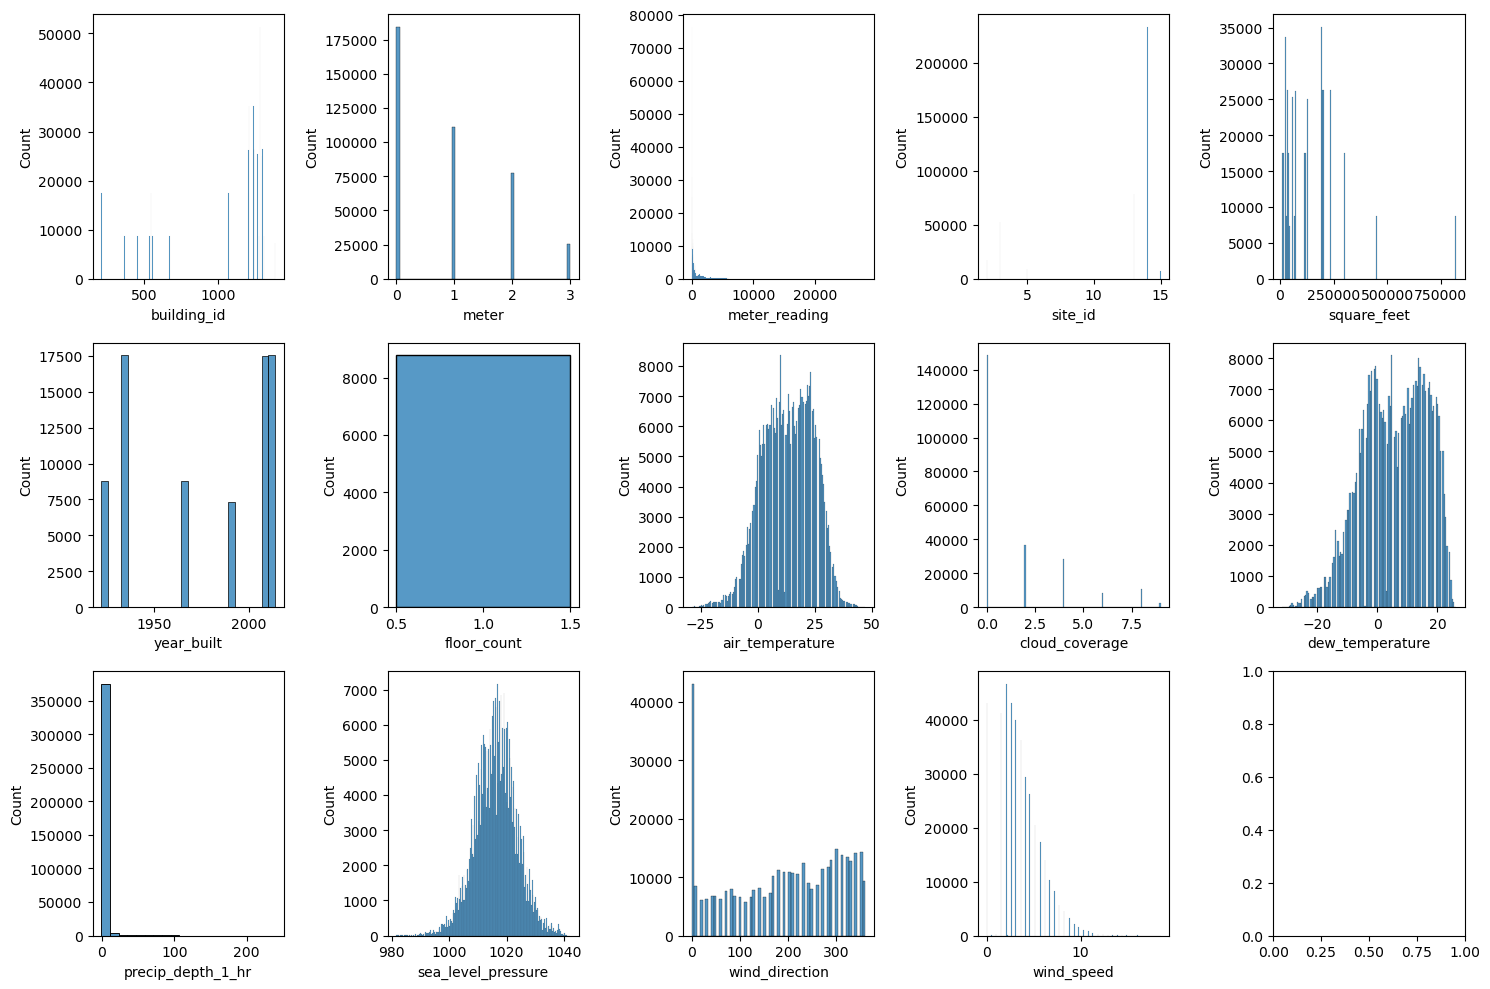

In [11]:
# Plotting the histograms 
plt.subplots(3,5, figsize=(15,10))

counter=1

for i in list(numeric):
    plt.subplot(3,5,counter)
    sns.histplot(healthcare_df[i])
    counter+=1

# Ensure proper spacing and no overlapping
plt.tight_layout()

**Insights**
- Positive skew for: `meter_reading`
- Bimodal distribution for `dew_temperature`
- Categorical structure for `meter`, `cloud_coverage`
- Normal distribution for: `sea_level_presure`

? Normal distribution for: air_temperature, sea_level_presure, square_feet \
? Positive skew for: wind_speed

[back to TOC](#toc)

<a id='hea-3'></a>

## 3.3. `Meter_reading` data analysis

Presents positive skew data with a lot of values near zero.

In [12]:
# Percentage of unique 'meter_reading' values
healthcare_df['meter_reading'].value_counts(normalize=True)

meter_reading
0.0000       0.087497
588.1900     0.004381
0.3748       0.002291
0.3332       0.002211
362.5400     0.001092
               ...   
230.1710     0.000003
2019.1500    0.000003
329.5960     0.000003
160.6970     0.000003
29.4019      0.000003
Name: proportion, Length: 195449, dtype: float64

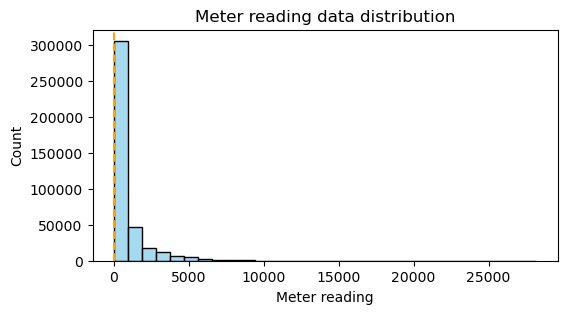

In [3]:
# Investigate meter_reading values for the full range of values
# Create histogram using Seaborn
plt.figure(figsize=(6,3))
sns.histplot(healthcare_df['meter_reading'], bins=30, color='skyblue')

# Adding a dotted vertical line where to zoom in
plt.axvline(x=1, color='orange', linestyle='--')

plt.xlabel('Meter reading')
plt.ylabel('Count')
plt.title('Meter reading data distribution')

plt.show()

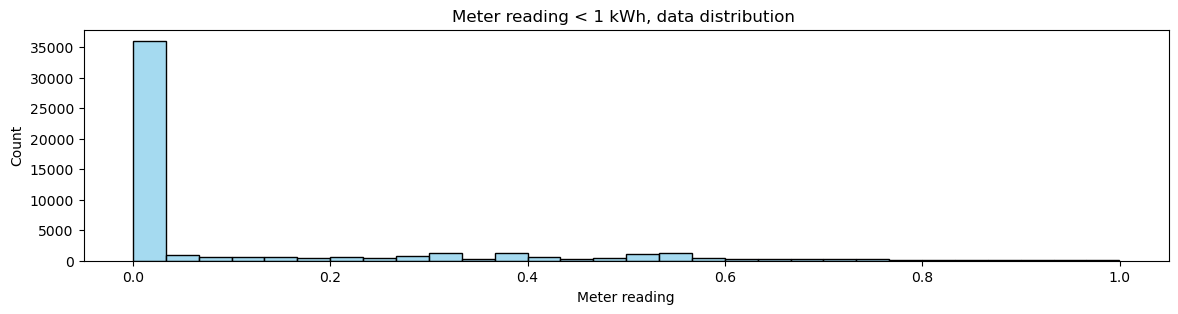

In [19]:
# Plot for count of meter_reading < 1

# Filtering data for 'meter_reading' 
filtered_data = healthcare_df[healthcare_df['meter_reading'] < 1]

# Creating a histogram using Seaborn
plt.figure(figsize=(14,3))
sns.histplot(filtered_data['meter_reading'], bins=30, color='skyblue')

plt.xlabel('Meter reading')
plt.ylabel('Count')
plt.title('Meter reading < 1 kWh, data distribution ')

plt.show()

**Insights**\
`meter_reading` values are in kWh units with are too small for hourly readings, change units to Wh. 

[back to TOC](#toc)

<a id='hea-4'></a>

## `dew_temperature` data analysis

Showing a bimodal distribution, i.e. it has has two modes, or two distinct clusters of data. Suggesting multiple locations and climates

<Axes: xlabel='dew_temperature', ylabel='Count'>

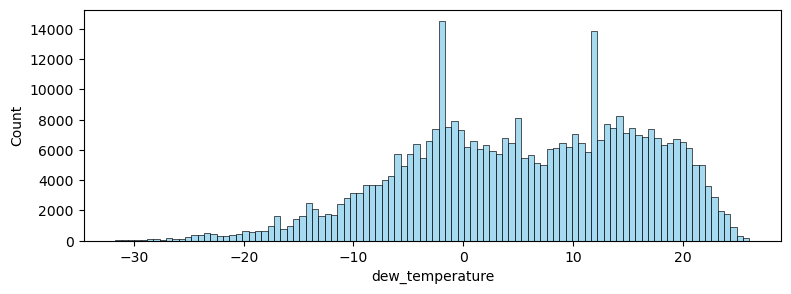

In [62]:
# Investigate meter_reading values for the full range of meter_reading values
# Create histogram using Seaborn
plt.figure(figsize=(9,3))
sns.histplot(healthcare_df['dew_temperature'], bins=100, color='skyblue')

[back to TOC](#toc)

<a id='hea-5'></a>

## `meter`, `cloud_coverage` data analysis

In [66]:
# Percentage of unique 'meter' values
healthcare_df['meter'].value_counts(normalize=True)

meter
0    0.462566
1    0.279339
2    0.194499
3    0.063597
Name: proportion, dtype: float64

<Axes: xlabel='meter', ylabel='Count'>

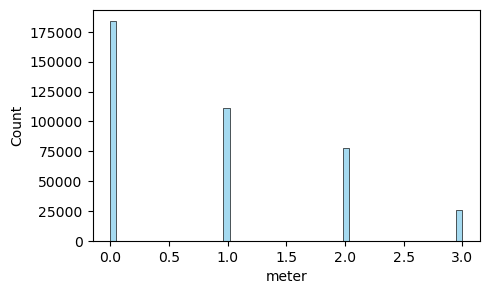

In [76]:
# Plot for 'meter'
plt.figure(figsize=(5,3))
sns.histplot(healthcare_df['meter'], color='skyblue')

In [67]:
# Percentage of 'cloud_coverage' values
healthcare_df['meter'].value_counts(normalize=True)

cloud_coverage
0.0    0.631388
2.0    0.156045
4.0    0.120315
8.0    0.046317
6.0    0.034897
9.0    0.011037
Name: proportion, dtype: float64

<Axes: xlabel='cloud_coverage', ylabel='Count'>

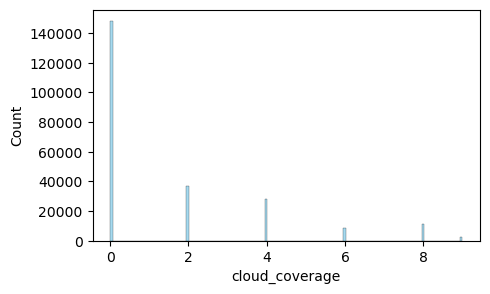

In [77]:
# Plot for 'cloud_coverage'
plt.figure(figsize=(5,3))
sns.histplot(healthcare_df['cloud_coverage'], color='skyblue')

**Insights**\
There is categorical structure for `meter`, `cloud_coverage`

[back to TOC](#toc)

<a id='hea-6'></a>

## `building_id` data analysis

In [79]:
healthcare_df['building_id'].nunique()

23

In [78]:
# Percentage of unique 'meter' values
healthcare_df['building_id'].value_counts(normalize=True)

building_id
1241    0.088114
1303    0.066123
1245    0.066086
1286    0.066083
1243    0.066078
1207    0.065694
1269    0.063697
1285    0.062789
1300    0.062520
1072    0.044082
1208    0.044075
1209    0.044072
208     0.044025
365     0.022041
670     0.022041
1282    0.022041
1313    0.022041
547     0.022036
455     0.022036
548     0.021976
535     0.021976
556     0.021973
1388    0.018398
Name: proportion, dtype: float64

<Figure size 800x600 with 0 Axes>

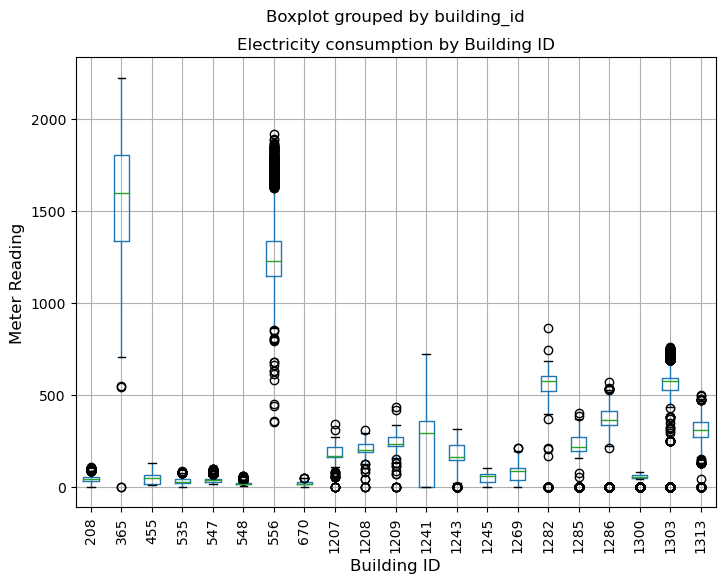

In [43]:
# Filtering data for 'meter' category 0: electricity, 1: chilled water, 2: steam, 3: hot water
meter_data = healthcare_df[healthcare_df['meter'] == 0]

# Creating a boxplot for 'meter_reading' values across 'building_id' for the 'meter' category
plt.figure(figsize=(8, 6)) 
meter_data.boxplot(column='meter_reading', by='building_id')

plt.xlabel('Building ID', fontsize=12)
plt.ylabel('Meter Reading', fontsize=12)
plt.title('Electricity consumption by Building ID')

# Rotating x-labels to 45 degrees
plt.xticks(rotation=90)

plt.show()

[back to TOC](#toc)

<a id='hea-7'></a>

## 3.7 Remove unnecessary and duplicated columns

In [112]:
# The column 'primary_use' can be drooped since it contains a single value 'Healthcare'
healthcare_df['primary_use'].value_counts()

primary_use
Healthcare    397992
Name: count, dtype: int64

The Healthcare total is equal to the total data frame rows, therefore, the column can be dropped 

In [113]:
# The column 'floor_count' can be drooped since it contains values equal to '1' or null
healthcare_df['floor_count'].value_counts()

floor_count
1.0    8755
Name: count, dtype: int64

In [114]:
# Quantity of null values
healthcare_df['floor_count'].isnull().sum()

389237

In [115]:
# Summing '1' and null
8755+389237

397992

The sum of '1' and null is equal to the total data frame rows, therefore, these are the only values and the column can be dropped. 

In [116]:
# Keep the column 'weather_timestamp' and drop 'meter_timestamp', since both have the same values.

In [117]:
comparison_timestamp = healthcare_df['meter_timestamp'] == healthcare_df['weather_timestamp']
comparison_timestamp.sum()

397992

Sum of the 'comparison_timestamp is equal to total rows, hence the columns have the same values and 'meter_timestamp' can be dropped. 

In [118]:
# Drop the three columns
healthcare_df.drop(columns=['primary_use','meter_timestamp','floor_count'], inplace=True)

In [119]:
# Rename the column 'weather_timestamp' to 'timestamp', for clarity.
healthcare_df.rename(columns={'weather_timestamp':'timestamp'}, inplace=True)

In [120]:
# Rename the column 'meter' to 'meter_type', for clarity.
healthcare_df.rename(columns={'meter':'meter_type'}, inplace=True)

In [121]:
# Converting to 'dateitme'
healthcare_df['timestamp']=healthcare_df['timestamp'].astype('datetime64[ns]')

# Sanity check
healthcare_df['timestamp'].dtype

dtype('<M8[ns]')

In [100]:
# Sanity check for verify the columns dropped and renamed.
healthcare_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397992 entries, 0 to 397991
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   building_id         397992 non-null  int64         
 1   meter_type          397992 non-null  int64         
 2   meter_reading       397992 non-null  float64       
 3   site_id             397992 non-null  int64         
 4   square_feet         397992 non-null  int64         
 5   year_built          77164 non-null   float64       
 6   timestamp           397992 non-null  datetime64[ns]
 7   air_temperature     397928 non-null  float64       
 8   cloud_coverage      235291 non-null  float64       
 9   dew_temperature     397913 non-null  float64       
 10  precip_depth_1_hr   382248 non-null  float64       
 11  sea_level_pressure  383709 non-null  float64       
 12  wind_direction      385758 non-null  float64       
 13  wind_speed          397313 no

In [122]:
# Verify if site 0 is in the data set, since for this site the electric meter readings are in kBTU, unlike the others in KWh
healthcare_df['site_id'].value_counts()

site_id
14    233181
13     78869
3      52597
2      17543
5       8755
15      7047
Name: count, dtype: int64

In [123]:
healthcare_df.sample(3)

,building_id,meter_type,meter_reading,site_id,square_feet,year_built,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
319064,1286,0,373.950,14,205472,NaN,2016-09-10 07:00:00,25.0,NaN,21.7,0.0,1014.2,0.0,0.0
258138,1285,2,285.573,14,130067,NaN,2016-06-06 09:00:00,18.9,0.0,17.8,0.0,1004.1,250.0,2.1
104346,1207,2,0.000,13,74443,NaN,2016-04-28 14:00:00,2.8,NaN,0.0,18.0,1015.0,60.0,6.7


In [218]:
# Export dataframe to a csv file
healthcare_df.to_csv('data/02_healthcare_duplicate_df.csv', index=False)

In [3]:
# Data loading for healthcare.csv saved from section above 'Basic Data Wrangling' . The file is coma (,) separated. The index is auto generated
healthcare_df=pd.read_csv('data/02_healthcare_duplicate_df.csv',sep=',')
healthcare_df.sample(3)

,building_id,meter_type,meter_reading,site_id,square_feet,year_built,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
44466,455,0,84.710,3,29192,2014.0,2016-07-07 00:00:00,30.6,4.0,22.8,0.0,1010.4,150.0,2.6
93297,1208,0,250.963,13,121585,NaN,2016-03-08 10:00:00,12.2,NaN,9.4,0.0,1002.0,140.0,4.6
126071,1209,0,216.393,13,115788,NaN,2016-08-07 04:00:00,21.7,2.0,13.9,0.0,1017.5,310.0,1.5


[back to TOC](#toc)

<a id='hea-8'></a>

## 3.8 Null values analysis

In [125]:
# Percentage of null values per column
healthcare_df.isna().mean()*100

building_id            0.000000
meter_type             0.000000
meter_reading          0.000000
site_id                0.000000
square_feet            0.000000
year_built            80.611671
timestamp              0.000000
air_temperature        0.016081
cloud_coverage        40.880470
dew_temperature        0.019850
precip_depth_1_hr      3.955858
sea_level_pressure     3.588766
wind_direction         3.073931
wind_speed             0.170606
dtype: float64

There are two columns with >40% of null values and three near to 4% null values. Each column will be analyzed to either drop it or fill in missing data.

#### 'year_built' null values analysis
80.6 % records missing, too many to be imputed.\
If bulding_id, site_id, square_feet are the same then use the year_built 

In [183]:
healthcare_df['year_built'].describe()

count    77164.000000
mean      1976.571847
std         36.542222
min       1922.000000
25%       1934.000000
50%       1990.000000
75%       2010.000000
max       2014.000000
Name: year_built, dtype: float64

<Axes: xlabel='year_built', ylabel='Count'>

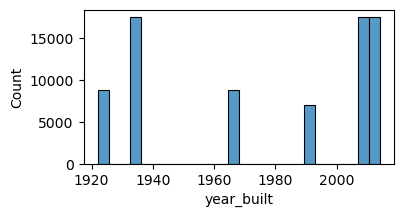

In [189]:
#  Plot
# Set the figure size
plt.figure(figsize=(4, 2))

# Create a histogram plot with Seaborn
sns.histplot(healthcare_df['year_built'])

In [5]:
# Percentage of current values
healthcare_df['year_built'].value_counts(normalize=True)

year_built
1934.0    0.227347
2010.0    0.226893
1922.0    0.113784
2014.0    0.113758
1966.0    0.113460
2012.0    0.113434
1990.0    0.091325
Name: proportion, dtype: float64

In [138]:
healthcare_df[healthcare_df['year_built'].isna()].sample(3)

,building_id,meter_type,meter_reading,site_id,square_feet,year_built,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
125558,1209,0,231.908,13,115788,NaN,2016-08-04 19:00:00,27.2,NaN,21.1,0.0,1009.2,230.0,4.6
209930,1241,3,625.001,14,194188,NaN,2016-03-23 03:00:00,8.9,NaN,-0.6,0.0,1016.4,190.0,5.1
359898,1303,2,3576.160,14,200000,NaN,2016-11-13 04:00:00,2.8,0.0,-4.4,0.0,1022.7,240.0,2.6


In [169]:
# Building_id associated with missing year_built
healthcare_df['building_id'][healthcare_df['year_built'].isna()].value_counts()

building_id
1241    35088
1303    26331
1245    26316
1286    26315
1243    26313
1207    26178
1269    25365
1285    25004
1300    24895
1072    17566
1208    17563
1209    17562
547      8778
1282     8777
1313     8777
Name: count, dtype: int64

In [182]:
healthcare_df[healthcare_df['square_feet']==68637].sample(3)

,building_id,meter_type,meter_reading,site_id,square_feet,year_built,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
167760,1313,0,308.36,14,68637,NaN,2016-01-16 14:00:00,5.0,NaN,3.9,-1.0,998.6,250.0,1.5
202690,1313,0,358.46,14,68637,NaN,2016-03-11 18:00:00,16.1,0.0,3.3,0.0,1020.1,350.0,5.7
349690,1313,0,362.54,14,68637,NaN,2016-10-28 07:00:00,9.4,0.0,7.8,0.0,1016.9,0.0,0.0


#### cloud_coverage null values
40.9 % records missing, too many to be imputed.

In [190]:
healthcare_df['cloud_coverage'].describe()

count    235291.000000
mean          1.472606
std           2.344205
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max           9.000000
Name: cloud_coverage, dtype: float64

<Axes: xlabel='cloud_coverage', ylabel='Count'>

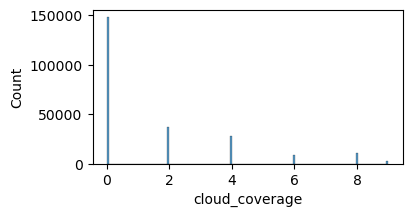

In [191]:
#  Plot
# Set the figure size
plt.figure(figsize=(4, 2))

# Create a histogram plot with Seaborn
sns.histplot(healthcare_df['cloud_coverage'])

In [192]:
# Percentage of current values
healthcare_df['cloud_coverage'].value_counts()/healthcare_df['cloud_coverage'].count()

cloud_coverage
0.0    0.631388
2.0    0.156045
4.0    0.120315
8.0    0.046317
6.0    0.034897
9.0    0.011037
Name: count, dtype: float64

**Insigh**\
Replace missing values with mode (0)\
df['cloud_coverage'].fillna(df['cloud_coverage'].mode(), inplace=True)

#### precip_depth_1_hr null values
3.96 % records missing

In [194]:
healthcare_df['precip_depth_1_hr'].describe()

count    382248.000000
mean          0.747271
std           6.126940
min          -1.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         239.000000
Name: precip_depth_1_hr, dtype: float64

<Axes: xlabel='precip_depth_1_hr', ylabel='Count'>

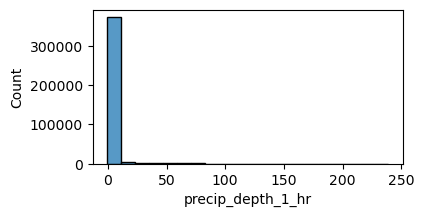

In [202]:
#  Plot
# Set the figure size
plt.figure(figsize=(4, 2))

# Create a histogram plot with Seaborn
sns.histplot(healthcare_df['precip_depth_1_hr'])

In [196]:
# Percentage of current values
healthcare_df['precip_depth_1_hr'].value_counts()/healthcare_df['precip_depth_1_hr'].count()

precip_depth_1_hr
 0.0      0.879589
-1.0      0.064660
 3.0      0.017646
 5.0      0.008413
 8.0      0.005606
            ...   
 132.0    0.000005
 147.0    0.000003
 211.0    0.000003
 180.0    0.000003
 239.0    0.000003
Name: count, Length: 71, dtype: float64

**Insigh**\
Replace missing values with mode (0)\
df['precip_depth_1_hr'].fillna(df['precip_depth_1_hr'].mode(), inplace=True)

#### sea_level_pressure null values
3.6 % records missing, 

In [203]:
healthcare_df['sea_level_pressure'].describe()

count    383709.000000
mean       1016.294189
std           7.296821
min         981.600000
25%        1011.600000
50%        1016.400000
75%        1021.000000
max        1042.200000
Name: sea_level_pressure, dtype: float64

<Axes: xlabel='sea_level_pressure', ylabel='Count'>

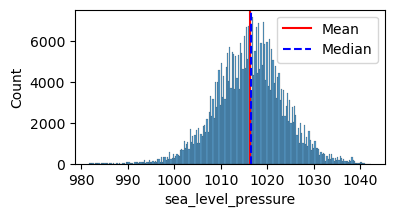

In [213]:
#  Plot
# Set the figure size
plt.figure(figsize=(4, 2))

# Adding statistical lines and legend
plt.axvline(healthcare_df['sea_level_pressure'].mean(), 0, 2000, c='r', label='Mean')
plt.axvline(healthcare_df['sea_level_pressure'].median(), 0, 2000, c='b', linestyle='--', label='Median')
plt.legend()

# Create a histogram plot with Seaborn
sns.histplot(healthcare_df['sea_level_pressure'])

In [205]:
# Percentage of current values
healthcare_df['sea_level_pressure'].value_counts()/healthcare_df['sea_level_pressure'].count()

sea_level_pressure
1015.8    0.007177
1015.2    0.006938
1016.7    0.006656
1017.7    0.006560
1019.0    0.006513
            ...   
994.4     0.000003
1041.0    0.000003
1040.5    0.000003
994.6     0.000003
1040.4    0.000003
Name: count, Length: 534, dtype: float64

**Insigh**\
Replace missing values with the mean, since it is the same as the median\
df['sea_level_pressure'].fillna(df['sea_level_pressure'].mean(), inplace=True)

#### wind_direction null values
3.1 % records missing, too many to be imputed.

In [206]:
healthcare_df['wind_direction'].describe()

count    385758.000000
mean        186.147621
std         116.653579
min           0.000000
25%          80.000000
50%         200.000000
75%         290.000000
max         360.000000
Name: wind_direction, dtype: float64

<Axes: xlabel='wind_direction', ylabel='Count'>

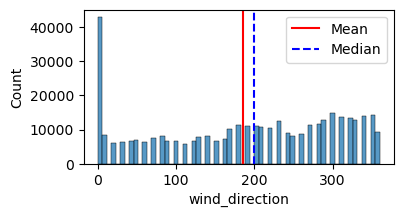

In [212]:
#  Plot
# Set the figure size
plt.figure(figsize=(4, 2))
plt.axvline(healthcare_df['wind_direction'].mean(), 0, 2000, c='r', label='Mean')
plt.axvline(healthcare_df['wind_direction'].median(), 0, 2000, c='b', linestyle='--', label='Median')
plt.legend()

# Create a histogram plot with Seaborn
sns.histplot(healthcare_df['wind_direction'])

In [208]:
# Percentage of current values
healthcare_df['wind_direction'].value_counts()/healthcare_df['wind_direction'].count()

wind_direction
0.0      0.111684
300.0    0.038260
350.0    0.037093
340.0    0.036476
310.0    0.035520
320.0    0.034675
290.0    0.033441
330.0    0.032922
230.0    0.032290
280.0    0.030182
270.0    0.029363
180.0    0.029127
200.0    0.028310
190.0    0.028251
210.0    0.027808
220.0    0.027224
170.0    0.026330
360.0    0.024378
240.0    0.023510
260.0    0.022501
10.0     0.022141
140.0    0.021301
80.0     0.020834
250.0    0.020637
130.0    0.020096
70.0     0.019660
160.0    0.018732
50.0     0.017578
40.0     0.017493
90.0     0.017428
150.0    0.017296
120.0    0.017262
100.0    0.016928
30.0     0.016306
60.0     0.016088
20.0     0.015715
110.0    0.015092
202.0    0.000070
Name: count, dtype: float64

**Insigh**\
Replace missing values with mean\
df['wind_direction'].fillna(df['wind_direction'].mean(), inplace=True)

#### wind_speed null values
0.2 % records missing, too many to be imputed.

In [214]:
healthcare_df['wind_speed'].describe()

count    397313.000000
mean          3.449965
std           2.223443
min           0.000000
25%           2.100000
50%           3.100000
75%           4.600000
max          18.500000
Name: wind_speed, dtype: float64

<Axes: xlabel='wind_speed', ylabel='Count'>

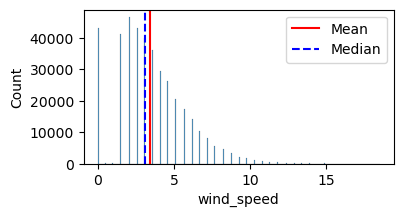

In [217]:
#  Plot
# Set the figure size
plt.figure(figsize=(4, 2))
plt.axvline(healthcare_df['wind_speed'].mean(), 0, 2000, c='r', label='Mean')
plt.axvline(healthcare_df['wind_speed'].median(), 0, 2000, c='b', linestyle='--', label='Median')
plt.legend()

# Create a histogram plot with Seaborn
sns.histplot(healthcare_df['wind_speed'])

In [216]:
# Percentage of current values
healthcare_df['wind_speed'].value_counts()/healthcare_df['wind_speed'].count()

wind_speed
2.1     0.117426
2.6     0.108627
0.0     0.108461
1.5     0.103863
3.1     0.100349
3.6     0.090938
4.1     0.073924
4.6     0.065971
5.1     0.051750
5.7     0.043583
6.2     0.035302
6.7     0.026040
7.2     0.020767
7.7     0.014392
8.2     0.011678
8.8     0.008386
9.3     0.005414
9.8     0.004098
10.3    0.002469
10.8    0.002089
11.3    0.001269
11.8    0.000891
12.4    0.000541
1.0     0.000506
12.9    0.000347
13.4    0.000242
0.5     0.000176
13.9    0.000169
14.9    0.000083
2.2     0.000060
14.4    0.000058
16.0    0.000045
1.3     0.000023
15.4    0.000018
17.0    0.000015
10.0    0.000015
13.0    0.000005
16.5    0.000003
18.5    0.000003
8.0     0.000003
7.0     0.000003
Name: count, dtype: float64

**Insigh**\
Replace missing values with mean\
df['wind_speed'].fillna(df['wind_speed'].mean(), inplace=True)

[back to TOC](#toc)

<a id='sa-0'></a>

# 3. Advanced Statistical Analysis

<a id='sa-1'></a>

## 3.1. Statistically significant difference

[back to TOC](#toc)

<a id='sa-2'></a>

## 3.2. Correlation with ??

[back to TOC](#toc)

<a id='asa-0'></a>

# 4. Advanced Statistical Analysis

<a id='asa-1'></a>

## 4.1. Linear regression for ??

[back to TOC](#toc)

<a id='asa-2'></a>

## 4.2. Logistic regression for ??

[back to TOC](#toc)

<a id='concl'></a>

# Conclusion

In

[back to TOC](#toc)

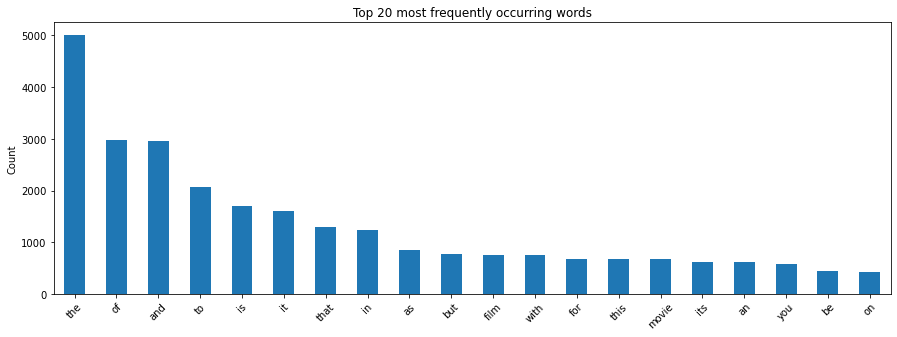

In [38]:
# graph syntax to use
word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)

plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()